In [1]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.15  Python-3.10.9 torch-2.5.0+cpu CPU (AMD Ryzen 5 5600H with Radeon Graphics)
Setup complete  (12 CPUs, 15.4 GB RAM, 192.1/475.2 GB disk)


In [21]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report
from ultralytics import YOLO
import torch
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import numpy as np

In [3]:
# Define paths
train_dir = 'C:/Users/nalwa/OneDrive/Documents/crop_disease_detection/dataset_1/PlantDoc-Dataset/train'
val_dir = 'C:/Users/nalwa/OneDrive/Documents/crop_disease_detection/dataset_1/PlantDoc-Dataset/validation'

In [4]:
print(os.listdir(train_dir))
print(os.listdir(val_dir))

['Apple leaf', 'Apple rust leaf', 'Apple Scab Leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Grape leaf', 'grape leaf black rot', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato Septoria leaf spot']
['Apple rust leaf', 'Apple Scab Leaf', 'Apple_leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'grape leaf', 'grape leaf black rot', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', '

In [5]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "validation": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}




In [6]:
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['validation'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))  # Adjust for the number of classes

c:\Users\nalwa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nalwa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# YOLOv8 Detection (Assuming you have YOLOv8 model)
def detect_with_yolov8(image_path):
    model_yolo = YOLO("yolov8s.pt")  # Pre-trained YOLOv8 model
    results = model_yolo(image_path)
    results.show()  # Display results

In [10]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move model to GPU/CPU

import matplotlib.pyplot as plt

# Training the CNN model (with GPU support) and storing loss
def train_model(model, criterion, optimizer, num_epochs=10, augment=True):
    model.train()
    epoch_losses = []  # List to store the loss for each epoch

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU/CPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_dataset)
        epoch_losses.append(epoch_loss)  # Store the epoch loss
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}')

    # Plot the loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), epoch_losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    # Save the trained model
    torch.save(model.state_dict(), 'crop_disease_model.pth')
    print('Model saved as crop_disease_model.pth')


In [11]:
# Evaluation (with GPU support)
def evaluate_model(model, val_loader, device):
    model.eval()  # Set to evaluation mode
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the predicted classes

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels, average='weighted')  # Use 'weighted' for multi-class
    conf_matrix = confusion_matrix(true_labels, pred_labels)

    # Print the classification report
    print(classification_report(true_labels, pred_labels, target_names=train_dataset.classes))

    return accuracy, f1, conf_matrix


Epoch 1/10, Loss: 2.651903425180313
Epoch 2/10, Loss: 2.041157281171511
Epoch 3/10, Loss: 1.7344035209774764
Epoch 4/10, Loss: 1.6088778313565708
Epoch 5/10, Loss: 1.3115571747619523
Epoch 6/10, Loss: 1.0899674076348078
Epoch 7/10, Loss: 0.9661211791856656
Epoch 8/10, Loss: 0.8007837180661577
Epoch 9/10, Loss: 0.7597704351051635
Epoch 10/10, Loss: 0.5762701344448731


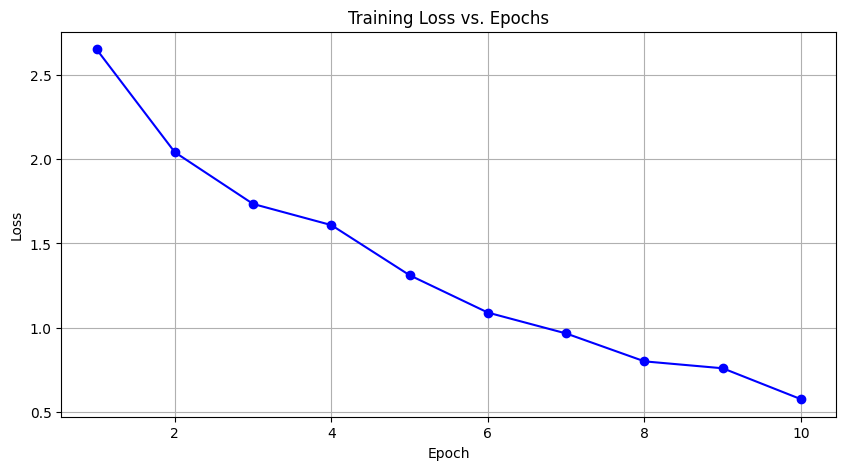

Model saved as crop_disease_model.pth
                            precision    recall  f1-score   support

           Apple Scab Leaf       0.18      0.22      0.20         9
                Apple leaf       0.00      0.00      0.00         9
           Apple rust leaf       0.00      0.00      0.00         7
          Bell_pepper leaf       0.29      0.25      0.27         8
     Bell_pepper leaf spot       0.18      0.33      0.23         9
            Blueberry leaf       0.00      0.00      0.00        11
               Cherry leaf       1.00      0.22      0.36         9
       Corn Gray leaf spot       0.05      0.33      0.08         3
          Corn leaf blight       0.14      0.09      0.11        11
            Corn rust leaf       0.38      0.50      0.43        10
                Grape leaf       0.00      0.00      0.00         8
                Peach leaf       0.00      0.00      0.00         7
  Potato leaf early blight       0.50      0.14      0.22         7
   Potato

c:\Users\nalwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nalwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nalwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [12]:
# Example usage after training your model
try:
    train_model(model, criterion, optimizer, num_epochs=10, augment=True)
    accuracy, f1, conf_matrix = evaluate_model(model, val_loader, device)
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    print("Confusion Matrix:\n", conf_matrix)
except Exception as e:
    print(f"An error occurred: {e}")



In [13]:
from PIL import Image
import torch
import os
from torchvision import transforms

# Function to predict class of a single image
def predict_image(image_path):
    model.eval()  # Set to evaluation mode
    img = Image.open(image_path)
    transform = data_transforms['validation']
    img = transform(img).unsqueeze(0)  # Add batch dimension
    img = img.to(device)  # Move to GPU/CPU

    with torch.no_grad():
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        class_name = train_dataset.classes[predicted.item()]  # Get predicted class
        return class_name

# Function to predict the class of multiple images in a folder
def predict_images_in_folder(folder_path):
    predictions = {}  # Dictionary to store image paths and their predicted class

    # Loop through all images in the folder
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)

        if img_file.endswith(('png', 'jpg', 'jpeg')):  # Check if it's an image file
            try:
                class_name = predict_image(img_path)  # Predict the class for each image
                predictions[img_file] = class_name
                print(f'Image: {img_file}, Predicted Class: {class_name}')
            except Exception as e:
                print(f"Error processing {img_file}: {e}")

    return predictions

In [14]:
# Example usage for a folder
folder_path = "C:/Users/nalwa/OneDrive/Documents/crop_disease_detection/dataset_1/PlantDoc-Dataset/test"
predictions = predict_images_in_folder(folder_path)

# Print the results
for img, pred in predictions.items():
    print(f"Image: {img},Predicted Class: {pred}")


Image: Apple rust leaf (32).jpg, Predicted Class: Apple rust leaf
Image: Apple Scab Leaf (43).jpg, Predicted Class: Apple Scab Leaf
Image: Bell_pepper leaf (7).jpg, Predicted Class: Bell_pepper leaf spot
Image: Bell_pepper leaf spot (26).jpg, Predicted Class: Bell_pepper leaf spot
Image: Corn Gray leaf spot (3).jpg, Predicted Class: Corn Gray leaf spot
Image: Corn leaf blight (3).jpg, Predicted Class: Corn Gray leaf spot
Image: Corn rust leaf (2).jpg, Predicted Class: Corn rust leaf
Image: grape leaf black rot (1).jpg, Predicted Class: grape leaf black rot
Image: Potato leaf early blight (3).jpg, Predicted Class: Apple rust leaf
Image: Potato leaf late blight (1).jpg, Predicted Class: Potato leaf late blight
Image: Squash Powdery mildew leaf (13).jpg, Predicted Class: Squash Powdery mildew leaf
Image: Squash Powdery mildew leaf (3).jpg, Predicted Class: Squash Powdery mildew leaf
Image: Tomato Early blight leaf (37).jpg, Predicted Class: Apple rust leaf
Image: Tomato Early blight leaf 

In [ ]:
#GUI

import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import os

# Function to clear the "user input" folder
def clear_previous_files():
    save_folder = "user input"
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    else:
        for filename in os.listdir(save_folder):
            file_path = os.path.join(save_folder, filename)
            if os.path.isfile(file_path):
                os.unlink(file_path)
        #print(f"All previous files removed from {save_folder}")

# Function to create the input window
def input_window():
    # Ensure the "user input" directory exists and is cleared
    clear_previous_files()
    
    # Define the constant name for the saved image
    save_folder = "user input"
    constant_image_name = "image.jpg"
    save_path = os.path.join(save_folder, constant_image_name)

    # Function to open the file dialog and save the image
    def open_and_save_image():
        # Open file dialog to select a .jpg file
        file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg")])
        
        if file_path:
            # Save the image to the "user input" folder with the constant name
            img = Image.open(file_path)
            img.save(save_path)
            #print(f"Image saved to: {save_path}")

            # Close the input window
            root.destroy()
            # Return the saved image path
            return save_path

    # Create the main window
    root = tk.Tk()
    root.title("Image Input")
    root.geometry("400x300")

    # Create a label widget for instructions
    label = tk.Label(root, text="Click the button to select a .jpg image", font=("Helvetica", 14))
    label.pack(pady=20)

    # Create a button to open and save the image
    button = tk.Button(root, text="Select and Save Image", command=open_and_save_image)
    button.pack(pady=20)

    # Start the Tkinter event loop
    root.mainloop()

# Run the input window
input_window()

# Cell 15.2
# Example usage for a single image

# Replace with the path of your image
image_path = "user input/image.jpg"  # e.g., "C:/path/to/your/image.jpg"

# Predict the class for the given image using the trained model
predicted_class = predict_image(image_path)

# Print the predicted class
print(f'Predicted class for the image {image_path}: {predicted_class}')

#cell 15.3
import tkinter as tk

# Dummy prediction function (replace with your actual model prediction)
def predict_image1(image_path):
    # Placeholder prediction logic
    pre = predicted_class
    return pre

# Function to create the prediction window
def prediction_window(image_path):
    # Function to close the prediction window
    def close_window():
        root.destroy()

    # Create the main window
    root = tk.Tk()
    root.title("Prediction Result")
    root.geometry("500x500")  # Adjusted to fit the image

    # Display the prediction result
    prediction = predict_image1(image_path)
    label = tk.Label(root, text=f"Prediction: {prediction}", font=("Helvetica", 14))
    label.pack(pady=20)

    # Display the image of the leaf
    img = Image.open(image_path)
    img = img.resize((300, 300))  # Resize for better fit
    img_tk = ImageTk.PhotoImage(img)

    image_label = tk.Label(root, image=img_tk)
    image_label.image = img_tk  # Keep a reference to avoid garbage collection
    image_label.pack(pady=20)

    # Create a button to close the window
    close_button = tk.Button(root, text="Close", command=close_window)
    close_button.pack(pady=20)

    # Start the Tkinter event loop
    root.mainloop()

# Use the saved image path from the "user input" folder
image_path = "user input/image.jpg"
prediction_window(image_path)


Predicted class for the image user input/image.jpg: Apple rust leaf


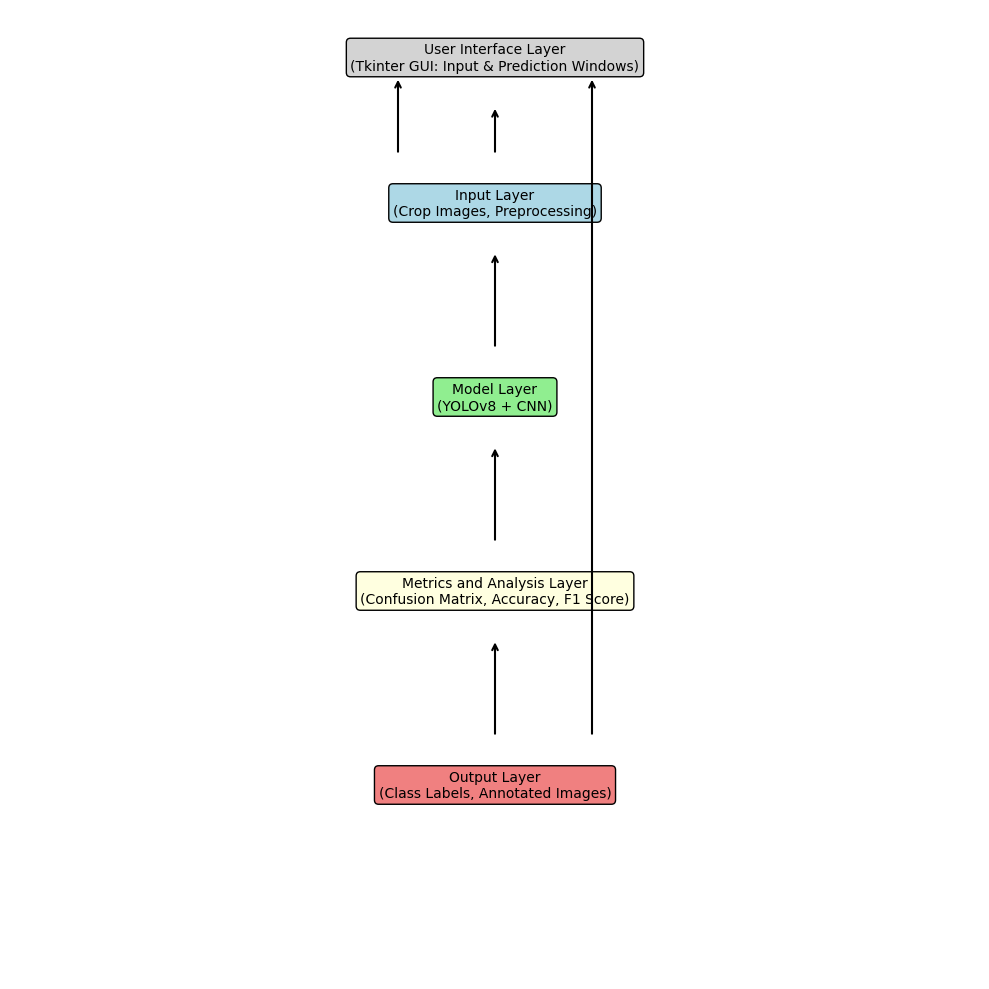

In [16]:
import matplotlib.pyplot as plt

# Create a figure
fig, ax = plt.subplots(figsize=(10, 10))

# Draw rectangles (text boxes)
ax.text(0.5, 0.95, "User Interface Layer\n(Tkinter GUI: Input & Prediction Windows)", ha="center", va="center",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgray"), fontsize=10)

ax.text(0.5, 0.8, "Input Layer\n(Crop Images, Preprocessing)", ha="center", va="center",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightblue"), fontsize=10)

ax.text(0.5, 0.6, "Model Layer\n(YOLOv8 + CNN)", ha="center", va="center",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgreen"), fontsize=10)

ax.text(0.5, 0.4, "Metrics and Analysis Layer\n(Confusion Matrix, Accuracy, F1 Score)", ha="center", va="center",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightyellow"), fontsize=10)

ax.text(0.5, 0.2, "Output Layer\n(Class Labels, Annotated Images)", ha="center", va="center",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightcoral"), fontsize=10)

# Draw arrows
ax.annotate('', xy=(0.5, 0.9), xytext=(0.5, 0.85), arrowprops=dict(arrowstyle="->", lw=1.5))
ax.annotate('', xy=(0.5, 0.75), xytext=(0.5, 0.65), arrowprops=dict(arrowstyle="->", lw=1.5))
ax.annotate('', xy=(0.5, 0.55), xytext=(0.5, 0.45), arrowprops=dict(arrowstyle="->", lw=1.5))
ax.annotate('', xy=(0.5, 0.35), xytext=(0.5, 0.25), arrowprops=dict(arrowstyle="->", lw=1.5))

# Additional arrows connecting GUI to input/output layers
ax.annotate('', xy=(0.4, 0.93), xytext=(0.4, 0.85), arrowprops=dict(arrowstyle="->", lw=1.5))
ax.annotate('', xy=(0.6, 0.93), xytext=(0.6, 0.25), arrowprops=dict(arrowstyle="->", lw=1.5))

# Hide axes
ax.axis('off')

# Save or display the diagram
plt.tight_layout()
plt.show()


Image: Apple rust leaf (32).jpg, Predicted Class: Apple rust leaf
Image: Apple Scab Leaf (43).jpg, Predicted Class: Apple Scab Leaf
Image: Bell_pepper leaf (7).jpg, Predicted Class: Bell_pepper leaf spot
Image: Bell_pepper leaf spot (26).jpg, Predicted Class: Bell_pepper leaf spot
Image: Corn Gray leaf spot (3).jpg, Predicted Class: Corn Gray leaf spot
Image: Corn leaf blight (3).jpg, Predicted Class: Corn Gray leaf spot
Image: Corn rust leaf (2).jpg, Predicted Class: Corn rust leaf
Image: grape leaf black rot (1).jpg, Predicted Class: grape leaf black rot
Error processing grape leaf black rot (1).jpg: 'Grape leaf black rot'
Image: Potato leaf early blight (3).jpg, Predicted Class: Apple rust leaf
Image: Potato leaf late blight (1).jpg, Predicted Class: Potato leaf late blight
Image: Squash Powdery mildew leaf (13).jpg, Predicted Class: Squash Powdery mildew leaf
Image: Squash Powdery mildew leaf (3).jpg, Predicted Class: Squash Powdery mildew leaf
Image: Tomato Early blight leaf (37).

c:\Users\nalwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nalwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


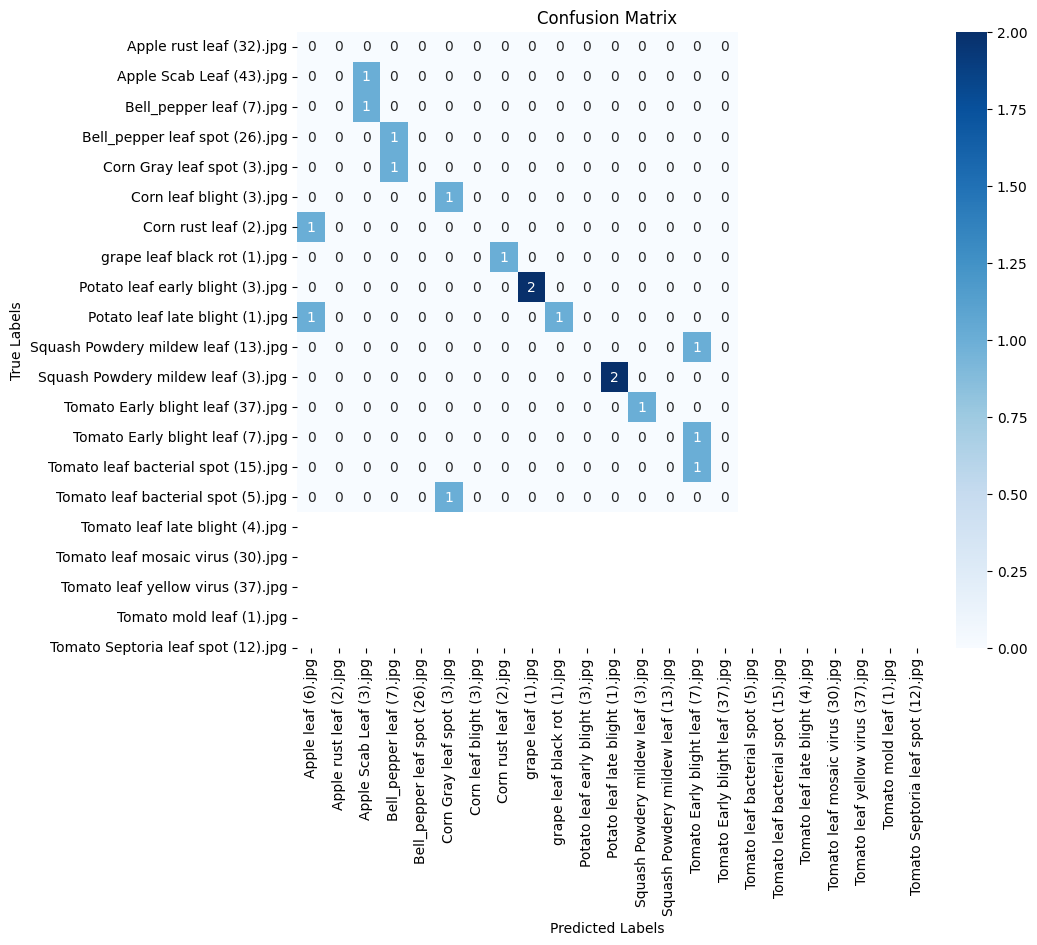

In [17]:
from sklearn.metrics import precision_score, recall_score
import seaborn as sns



def predict_images_in_folder(folder_path, true_labels):
    predictions = {}  # Store image paths and their predicted class
    all_true_labels = []  # List to store true labels
    all_pred_labels = []  # List to store predicted labels

    # Map class names to indices for true labels
    class_to_idx = train_dataset.class_to_idx

    # Loop through all images in the folder
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        
        # Check if it's an image file
        if img_file.endswith(('png', 'jpg', 'jpeg')):
            try:
                predicted_class = predict_image(img_path)  # Predict the class for each image
                predictions[img_file] = predicted_class
                print(f'Image: {img_file}, Predicted Class: {predicted_class}')

                # Get true label from `true_labels` dictionary if available
                true_class_name = true_labels.get(img_file, None)
                
                if true_class_name:
                    all_true_labels.append(class_to_idx[true_class_name])
                    all_pred_labels.append(class_to_idx[predicted_class])
                else:
                    print(f"Warning: True label for {img_file} not provided.")

            except Exception as e:
                print(f"Error processing {img_file}: {e}")

    # Calculate and print evaluation metrics if true labels are available
    if all_true_labels:
        accuracy = accuracy_score(all_true_labels, all_pred_labels)
        precision = precision_score(all_true_labels, all_pred_labels, average='weighted')
        recall = recall_score(all_true_labels, all_pred_labels, average='weighted')
        f1 = f1_score(all_true_labels, all_pred_labels, average='weighted')
        conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)

        # Print metrics
        print("\nEvaluation Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("Confusion Matrix:\n", conf_matrix)

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=true_labels, yticklabels=predictions)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()


    return predictions

# Define true_labels dictionary with image filenames and their corresponding true classes
true_labels = {
    "Apple leaf (6).jpg": "Apple leaf",
    "Apple rust leaf (2).jpg": "Apple rust leaf",
    "Apple Scab Leaf (3).jpg": "Apple Scab Leaf",
    "Bell_pepper leaf (7).jpg": "Bell_pepper leaf",
    "Bell_pepper leaf spot (26).jpg": "Bell_pepper leaf spot",
    "Corn Gray leaf spot (3).jpg": "Corn Gray leaf spot",
    "Corn leaf blight (3).jpg": "Corn leaf blight",
    "Corn rust leaf (2).jpg": "Corn rust leaf",
    "grape leaf (1).jpg": "Grape leaf",
    "grape leaf black rot (1).jpg": "Grape leaf black rot",
    "Potato leaf early blight (3).jpg": "Potato leaf early blight",
    "Potato leaf late blight (1).jpg": "Potato leaf late blight",
    "Squash Powdery mildew leaf (3).jpg": "Squash Powdery mildew leaf",
    "Squash Powdery mildew leaf (13).jpg": "Squash Powdery mildew leaf",
    "Tomato Early blight leaf (7).jpg": "Tomato Early blight leaf",
    "Tomato Early blight leaf (37).jpg": "Tomato Early blight leaf",
    "Tomato leaf bacterial spot (5).jpg": "Tomato leaf bacterial spot",
    "Tomato leaf bacterial spot (15).jpg": "Tomato leaf bacterial spot",
    "Tomato leaf late blight (4).jpg": "Tomato leaf late blight",
    "Tomato leaf mosaic virus (30).jpg": "Tomato leaf mosaic virus",
    "Tomato leaf yellow virus (37).jpg": "Tomato leaf yellow virus",
    "Tomato mold leaf (1).jpg": "Tomato mold leaf",
    "Tomato Septoria leaf spot (12).jpg": "Tomato Septoria leaf spot",
}


# Call the function with `folder_path` and `true_labels`
folder_path = "C:/Users/nalwa/OneDrive/Documents/crop_disease_detection/dataset_1/PlantDoc-Dataset/test"
predictions = predict_images_in_folder(folder_path, true_labels)


In [18]:
print("True labels:", true_labels)
print("Predicted labels:", predictions)

True labels: {'Apple leaf (6).jpg': 'Apple leaf', 'Apple rust leaf (2).jpg': 'Apple rust leaf', 'Apple Scab Leaf (3).jpg': 'Apple Scab Leaf', 'Bell_pepper leaf (7).jpg': 'Bell_pepper leaf', 'Bell_pepper leaf spot (26).jpg': 'Bell_pepper leaf spot', 'Corn Gray leaf spot (3).jpg': 'Corn Gray leaf spot', 'Corn leaf blight (3).jpg': 'Corn leaf blight', 'Corn rust leaf (2).jpg': 'Corn rust leaf', 'grape leaf (1).jpg': 'Grape leaf', 'grape leaf black rot (1).jpg': 'Grape leaf black rot', 'Potato leaf early blight (3).jpg': 'Potato leaf early blight', 'Potato leaf late blight (1).jpg': 'Potato leaf late blight', 'Squash Powdery mildew leaf (3).jpg': 'Squash Powdery mildew leaf', 'Squash Powdery mildew leaf (13).jpg': 'Squash Powdery mildew leaf', 'Tomato Early blight leaf (7).jpg': 'Tomato Early blight leaf', 'Tomato Early blight leaf (37).jpg': 'Tomato Early blight leaf', 'Tomato leaf bacterial spot (5).jpg': 'Tomato leaf bacterial spot', 'Tomato leaf bacterial spot (15).jpg': 'Tomato leaf b

In [26]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Function to calculate BLEU score
def calculate_bleu_score(True_labels, Predicted_labels):
    bleu_scores = []
    smoothing = SmoothingFunction()

    for true_label, pred_label in zip(True_labels, Predicted_labels):
        reference = [true_label.split()]  # True class as a list of words
        hypothesis = pred_label.split()    # Predicted class as a list of words

        # # Debug output
        # print(f"Reference: {reference}, Hypothesis: {hypothesis}")

        score = sentence_bleu(reference, hypothesis, smoothing_function=smoothing.method1)
        bleu_scores.append(score)

    avg_bleu = np.mean(bleu_scores)
    return avg_bleu

# Example usage after evaluating the model
True_labels = ["Apple leaf", "Apple rust leaf", "Apple Scab Leaf", "Bell_pepper leaf", "Bell_pepper leaf", "Bell_pepper leaf spot", "Bell_pepper leaf spot", "Blueberry leaf", "Cherry leaf", "Corn Gray leaf spot", "Corn leaf blight", "Grape leaf", "Grape leaf black rot", "Grape leaf black rot", "Peach leaf", "Potato leaf early blight", "Potato leaf late blight", "Raspberry leaf", "Soyabean leaf", "Soyabean leaf", "Soyabean leaf", "Soyabean leaf"]

Predicted_labels = ["Soyabean leaf", "Apple rust leaf", "grape leaf black rot", "Bell_pepper leaf", "Bell_pepper leaf", "Bell_pepper leaf spot", "Bell_pepper leaf spot", "Blueberry leaf", "Raspberry leaf", "Corn leaf blight", "Corn leaf blight", "Grape leaf", "grape leaf black rot", "grape leaf black rot", "Peach leaf", "Potato leaf early blight", "Potato leaf early blight", "Strawberry leaf", "Soyabean leaf", "Apple leaf", "Soyabean leaf", "Soyabean leaf"]  # Replace with actual predicted labels

# Calculate and print the average BLEU score
bleu_score = calculate_bleu_score(true_labels, Predicted_labels)
print(f"Average BLEU Score: {bleu_score:.4f}")


Average BLEU Score: 0.0817


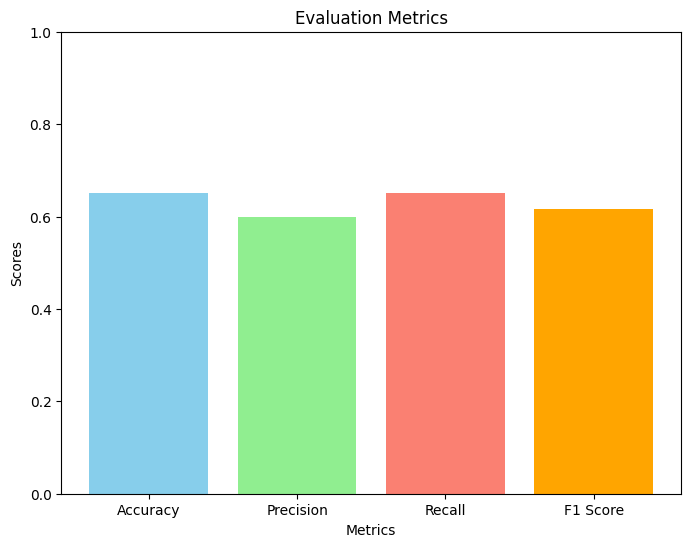

In [20]:
import matplotlib.pyplot as plt

# Evaluation metrics data
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [0.65, 0.60, 0.65, 0.6167]

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon', 'orange'])
plt.ylim(0, 1)  # Set y-axis limit to 1 for better comparison
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.title("Evaluation Metrics")
plt.show()
